In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
# from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  

In [2]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv, integrate_keypoints_with_video_time

#keypoints
keypoint_dfs = load_keypoints_from_csv('/root/capsule/data/matt_test_DLC_LP_results_20240920/outputs/video_preds3/bottom_camera.csv')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed, keypoint_timebase = integrate_keypoints_with_video_time(
    '/root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.csv', 
    keypoint_dfs
)

keypoints extracted: ['nose_tip', 'tongue_tip', 'jaw', 'pointer_finger_l', 'pointer_finger_r', 'spout_l', 'spout_r']
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718


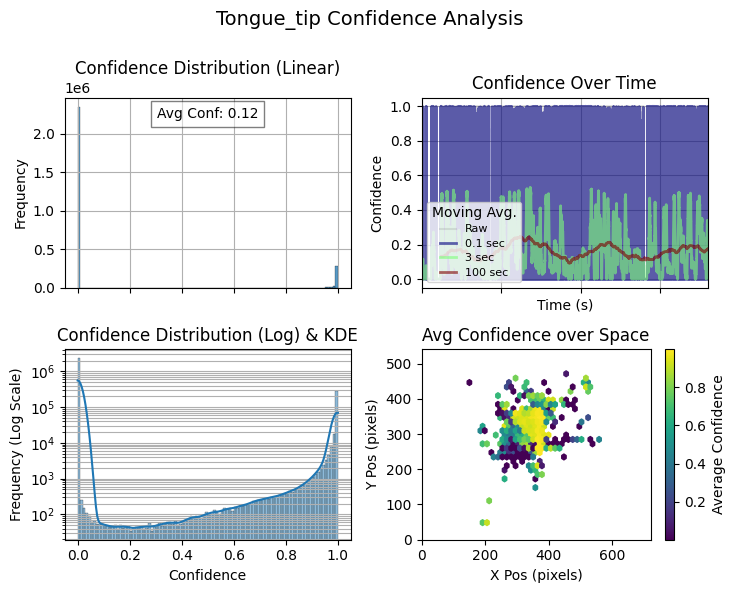

In [3]:
from tongue_kinematics_utils import plot_keypoint_confidence_analysis

plot_keypoint_confidence_analysis(keypoint_dfs_trimmed, 'tongue_tip')



In [3]:
#tongue kinematics processing and annotation
from tongue_kinematics_utils import mask_keypoint_data, kinematics_filter, segment_movements
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=20,filter_order=4)
tongue_segmented = segment_movements(tongue_filtered, max_dropped_frames=10)


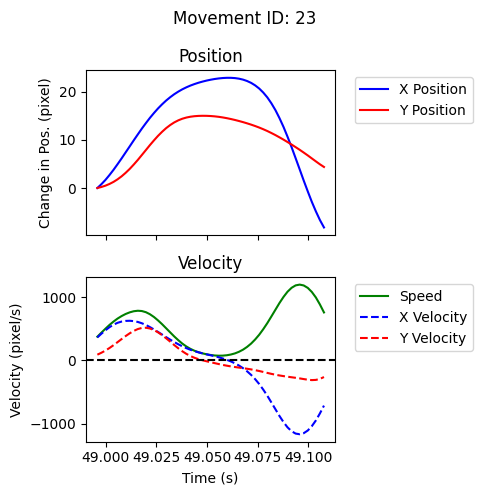

In [4]:
from tongue_kinematics_utils import plot_basic_kinematics_movement_segment

plot_basic_kinematics_movement_segment(tongue_segmented, movement_ids = 23)


Other plotting functions

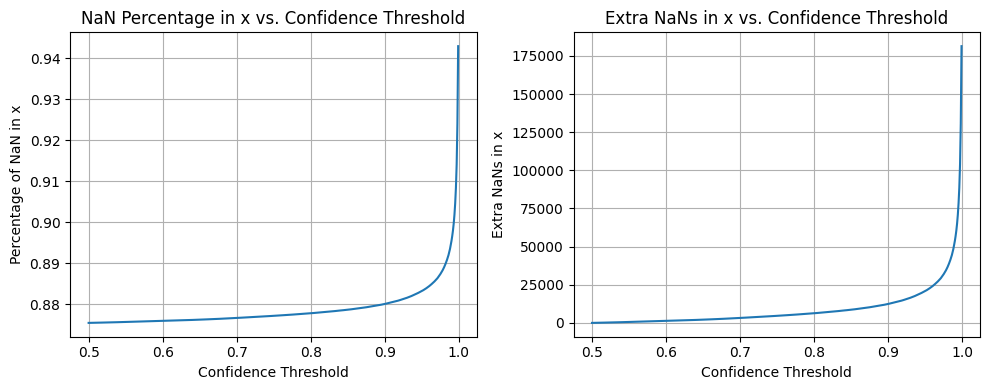

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Define confidence thresholds to iterate over
confidence_thresholds = np.arange(0.5, 1.0, 0.001)

nan_percentages = []
nan_counts = []
extra_nans = []

total_length = len(keypoint_dfs_trimmed)  # Assuming length is constant
baseline_nan_count = None

for threshold in confidence_thresholds:
    tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed, 'tongue_tip', confidence_threshold=threshold)
    nan_count = tongue_masked['x'].isna().sum()
    nan_percentage = nan_count / len(tongue_masked['x'])
    nan_counts.append(nan_count)
    nan_percentages.append(nan_percentage)
    
    if baseline_nan_count is None:
        baseline_nan_count = nan_count  # Set baseline at first threshold (0.5)
    extra_nans.append(nan_count - baseline_nan_count)

# Plot results
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Percentage plot
axs[0].plot(confidence_thresholds, nan_percentages, linestyle='-')
axs[0].set_xlabel('Confidence Threshold')
axs[0].set_ylabel('Percentage of NaN in x')
axs[0].set_title('NaN Percentage in x vs. Confidence Threshold')
axs[0].grid(True)

# Extra NaN count plot
axs[1].plot(confidence_thresholds, extra_nans, linestyle='-')
axs[1].set_xlabel('Confidence Threshold')
axs[1].set_ylabel('Extra NaNs in x')
axs[1].set_title('Extra NaNs in x vs. Confidence Threshold')
axs[1].grid(True)

plt.tight_layout()
plt.show()


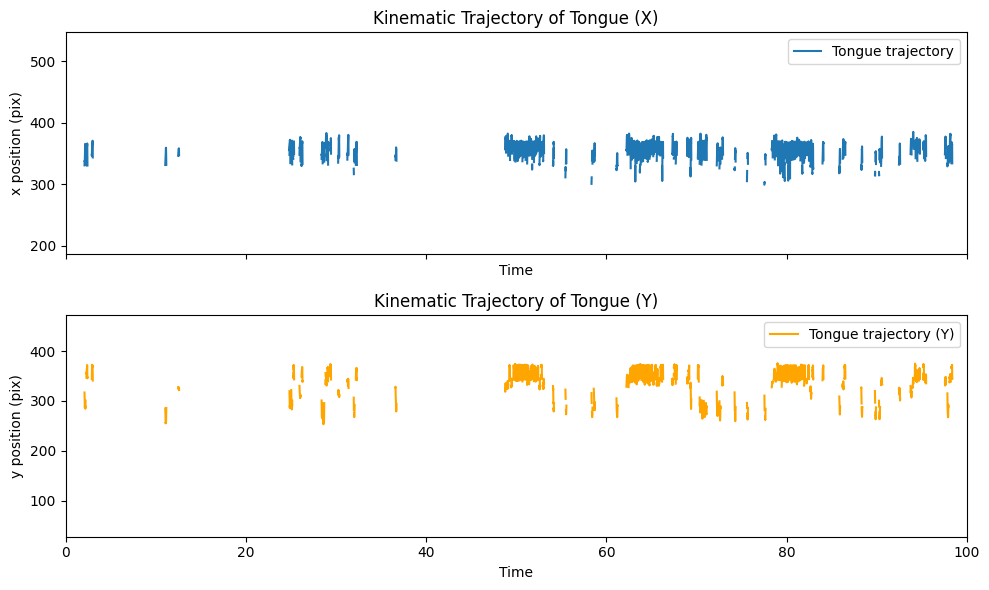

In [15]:
# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 6),sharex=True)

# First subplot
axs[0].plot(tongue_masked['time'], tongue_masked['x'], linestyle='-', label='Tongue trajectory')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('x position (pix)')
axs[0].set_title('Kinematic Trajectory of Tongue (X)')
axs[0].legend()

# Second subplot
axs[1].plot(tongue_masked['time'], tongue_masked['y'], linestyle='-', label='Tongue trajectory (Y)', color='orange')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('y position (pix)')
axs[1].set_title('Kinematic Trajectory of Tongue (Y)')
axs[1].legend()

time_len = 100
start_time = 0

plt.setp(axs,xlim = [tongue_masked['time'][0]+start_time, tongue_masked['time'][0]+start_time+time_len])
# Adjust layout
plt.tight_layout()
plt.show()


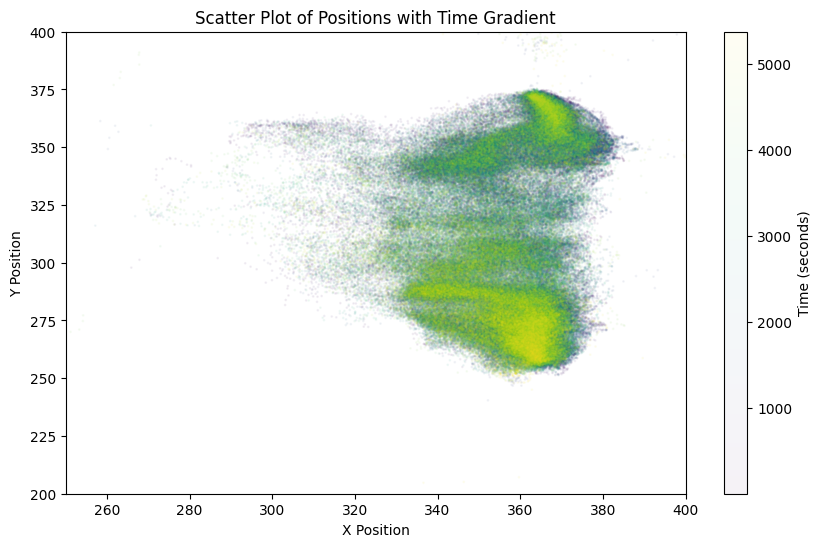

In [6]:
# Create scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(tongue_masked['x'], tongue_masked['y'], c=tongue_masked['time'], cmap='viridis', s=1, alpha=0.05)
plt.colorbar(sc, label='Time (seconds)')
plt.title('Scatter Plot of Positions with Time Gradient')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.xlim(250,400)
plt.ylim(200,400)
plt.show()

In [7]:
# plt.figure(figsize=(10, 6))
# ax_kde = sns.kdeplot(x=tongue_masked['x'], y=tongue_masked['y'], cmap='viridis', fill=True, thresh=0, levels=30)
# plt.title('Heatmap of Positions')
# plt.xlabel('X Position')
# plt.ylabel('Y Position')
# plt.xlim(250,400)
# plt.ylim(200,400)

# # with spouts
# spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x', 'y']],0)
# spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x', 'y']],0)
# plt.scatter(spoutR['x'],spoutR['y'], c = 'red', s = 40)
# plt.scatter(spoutL['x'],spoutL['y'], c = 'blue', s = 40)

# plt.show()

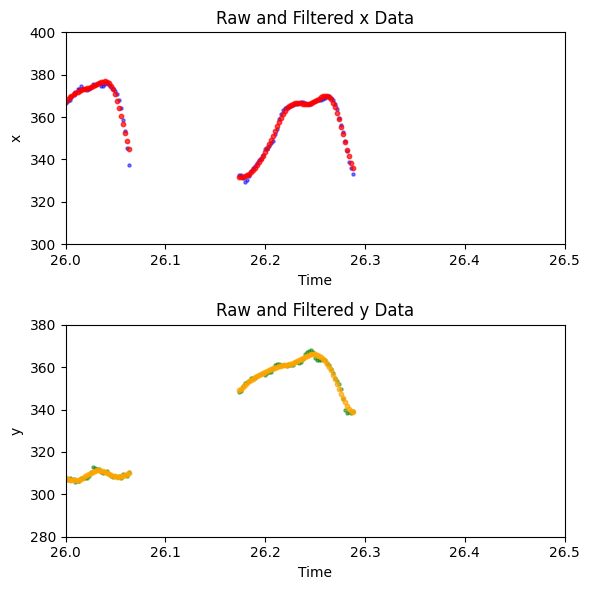

In [5]:
df = tongue_masked.copy()
df_filtered = tongue_filtered.copy()

# Define your desired x-axis limits
x_limits = (tongue_masked['time'][0]+26, tongue_masked['time'][0]+26.5)  # Replace with your desired limits, e.g., (2, 5)

# Plotting for 'x'
plt.figure(figsize=(6, 6))

plt.subplot(2, 1, 1)
plt.scatter(df['time'], df['x'], label='Raw x', color='blue', alpha=0.5, s=5)  # Raw data
plt.scatter(df_filtered['time'], df_filtered['x'], label='Filtered x', color='red', alpha=0.7, s=10)  # Filtered data
plt.title('Raw and Filtered x Data')
plt.xlabel('Time')
plt.ylabel('x')
plt.xlim(x_limits)  # Set x-axis limits
plt.ylim([300, 400])

# Plotting for 'y'
plt.subplot(2, 1, 2)
plt.scatter(df['time'], df['y'], label='Raw y', color='green', alpha=0.5, s=5)  # Raw data
plt.scatter(df_filtered['time'], df_filtered['y'], label='Filtered y', color='orange', alpha=0.7, s=10)  # Filtered data
plt.title('Raw and Filtered y Data')
plt.xlabel('Time')
plt.ylabel('y')
plt.xlim(x_limits)  # Set x-axis limits
plt.ylim([280, 380])


plt.tight_layout()
plt.show()


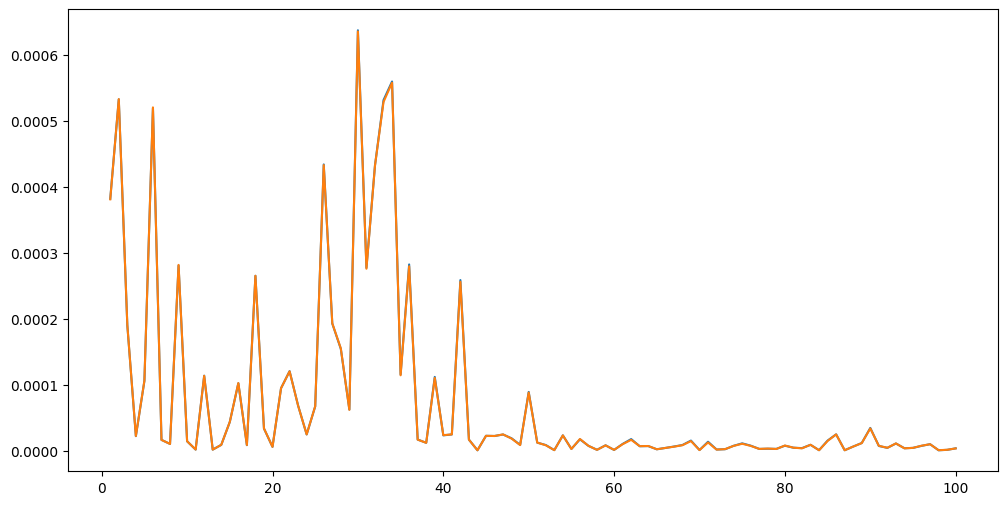

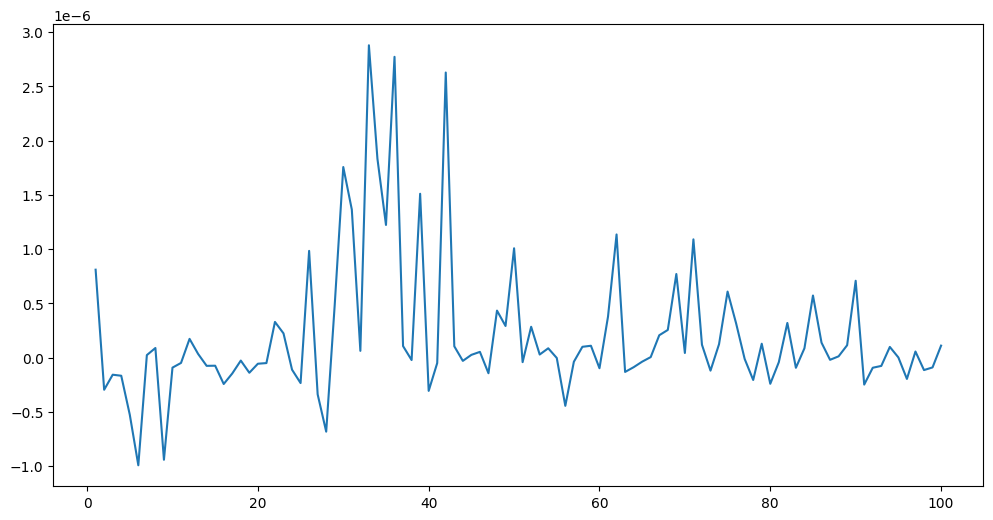

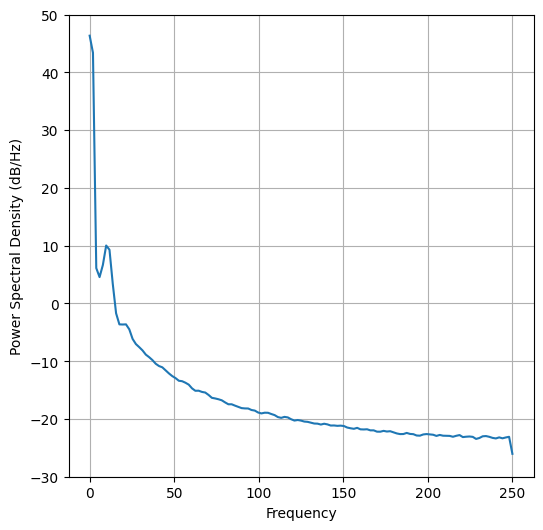

In [51]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Filter out NaN values from the time and x data
time = df['time']
x = df['x']

# Mask NaN values
mask = ~np.isnan(time) & ~np.isnan(x)
time = time[mask]
x = x[mask]

# Set up the frequency range
w = np.linspace(1, 100, 100)

# Compute the Lomb-Scargle periodogram
pgram = signal.lombscargle(time, x, w, normalize=True)


# Filter out NaN values from the time and x data
time_filtered = df_filtered['time']
x_filtered = df_filtered['x']

# Mask NaN values
mask = ~np.isnan(time_filtered) & ~np.isnan(x_filtered)
time_filtered = time_filtered[mask]
x_filtered = x_filtered[mask]


# Compute the Lomb-Scargle periodogram
pgram_filtered = signal.lombscargle(time_filtered, x_filtered, w, normalize=True)

# Plot the result
plt.figure(figsize=(12, 6))
plt.plot(w, pgram)
plt.plot(w, pgram_filtered)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(w, pgram-pgram_filtered)
plt.show()



#check out normal psd (although not sure if it is valid due to uneven sampling)
plt.figure(figsize=(6, 6))
plt.psd(x_filtered,Fs=500)
plt.show()

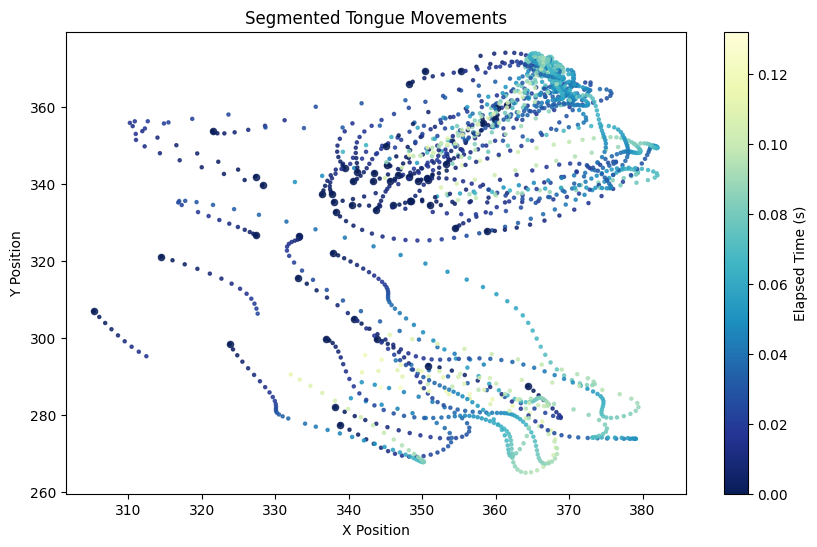

In [19]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import numpy as np
import pandas as pd

def plot_segmented_movements_global_time_colored(df, movement_id_range=None):
    # Create a figure and axis explicitly
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Filter movement IDs if a range or specific ID is provided
    if movement_id_range is not None:
        df = df[df['movement_id'].isin(movement_id_range if isinstance(movement_id_range, list) else [movement_id_range])]
    
    # Compute the elapsed time for each movement and determine the global maximum elapsed time
    elapsed_times = df.groupby('movement_id')['time'].apply(lambda x: x.max() - x.min())
    global_max_elapsed = elapsed_times.max()
    
    # Set up a common colormap and normalization
    cmap = plt.get_cmap('YlGnBu_r')
    norm = colors.Normalize(vmin=0, vmax=global_max_elapsed)
    
    for movement_id, segment in df.groupby('movement_id'):
        if pd.notna(movement_id):
            # Calculate elapsed time relative to the start of the movement
            elapsed_time = segment['time'] - segment['time'].min()
            
            # Mark the start point of the movement
            ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0],
                       c=[elapsed_time.iloc[0]], cmap=cmap, norm=norm, s=20, alpha=0.8)
            
            # Plot the segment with color gradient based on elapsed time
            ax.scatter(segment['x'], segment['y'], c=elapsed_time, cmap=cmap, norm=norm, s=5, alpha=0.8)
    
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    
    # Create a global colorbar that represents elapsed time from 0 to global_max_elapsed
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Only needed for matplotlib < 3.1
    fig.colorbar(sm, ax=ax, label='Elapsed Time (s)')
    
    ax.set_title('Segmented Tongue Movements')
    plt.show()

plot_segmented_movements_global_time_colored(tongue_segmented, movement_id_range = list(range(50,100)))

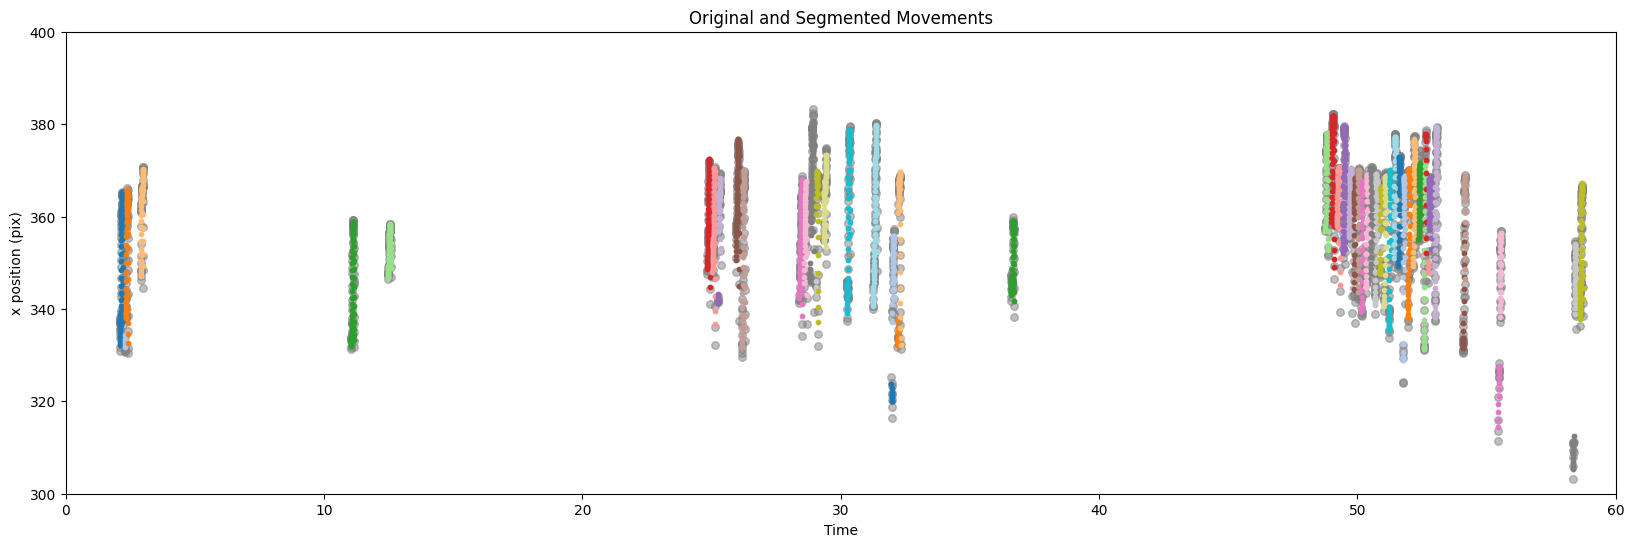

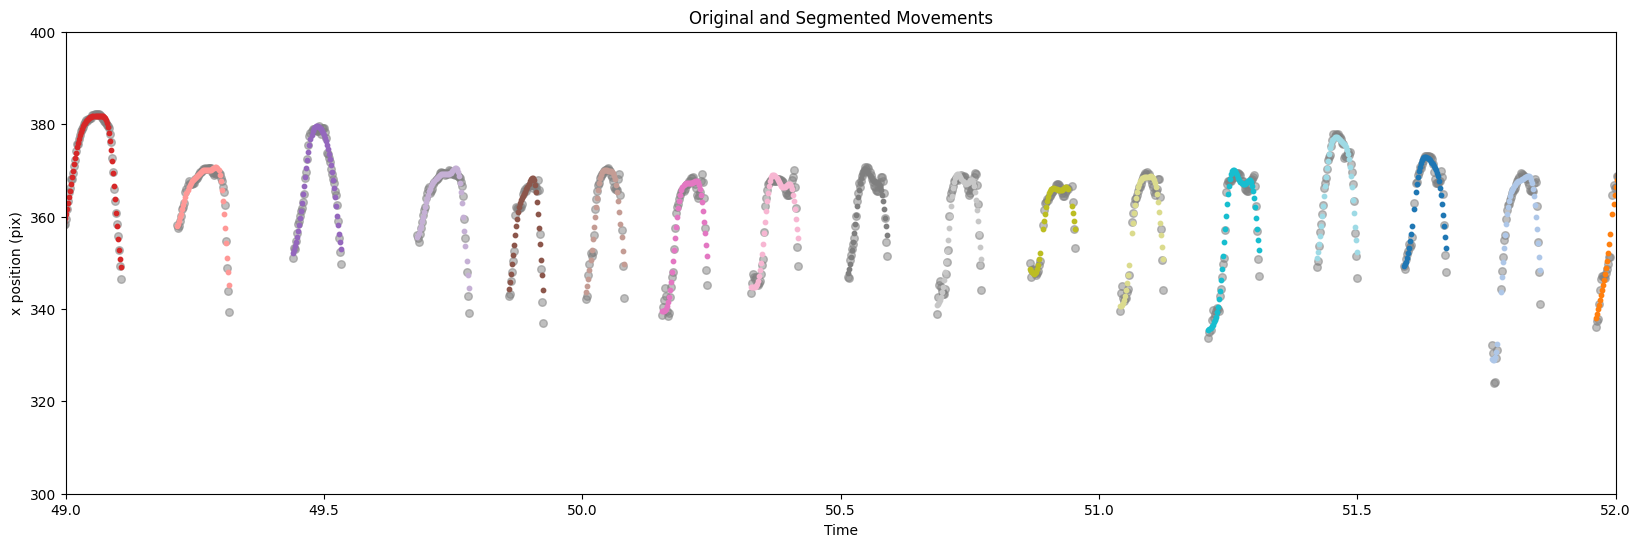

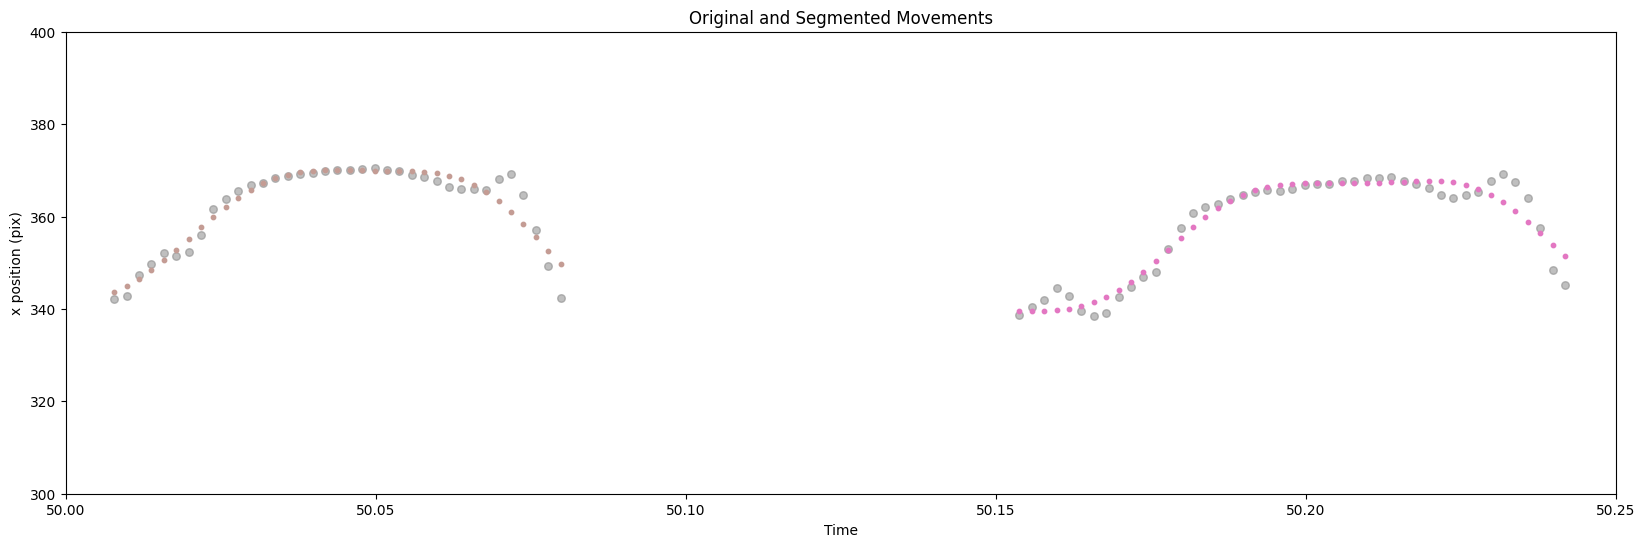

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_original_and_segmented_data(original_data, segmented_data, xlim=None):
    plt.figure(figsize=(20, 6))

    # Plot the original data in gray
    plt.scatter(original_data['time'], original_data['x'], color='gray', s=30, 
                label='Original Data', alpha=0.5)
    
    # Get unique movement IDs (excluding NaN) and assign a distinct color for each
    unique_ids = sorted(segmented_data['movement_id'].dropna().unique())
    num_colors = 20  # tab20 has 20 distinct colors
    colors = plt.cm.tab20(np.arange(len(unique_ids)) % num_colors)
    color_mapping = {mid: colors[i] for i, mid in enumerate(unique_ids)}
    
    # Group by movement_id and plot each segment with its assigned color
    for movement_id, group in segmented_data.groupby('movement_id'):
        if pd.notna(movement_id):
            plt.scatter(group['time'], group['x'], 
                        color=color_mapping[movement_id], s=10, 
                        label=f'Movement {int(movement_id)}')
    
    plt.xlabel('Time')
    plt.ylabel('x position (pix)')
    plt.title('Original and Segmented Movements')
    
    # Set x-axis limits
    if xlim is not None:
        plt.xlim(xlim)
    else:
        # If no xlim is provided, extend x-axis from 0 to the maximum time in original data
        plt.xlim([0, original_data['time'].max()])
    
    # Set y-axis limits as desired (in this case, from 300 to 400)
    plt.ylim([300, 400])
    plt.show()
plot_original_and_segmented_data(tongue_masked, tongue_segmented, xlim=[0, 60])
plot_original_and_segmented_data(tongue_masked, tongue_segmented, xlim=[49,52])
plot_original_and_segmented_data(tongue_masked, tongue_segmented, xlim=[50,50.25])

In [ ]:
# to do next: integrate with nwb behavior dataframe

In [17]:
# pip install aind_dynamic_foraging_data_utils

In [18]:
from aind_dynamic_foraging_data_utils import nwb_utils


# get list of available sessions
file_pattern = "*.nwb"
nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
file_list = glob.glob(os.path.join(nwb_folder + "/" + file_pattern))
file_names = [os.path.basename(file) for file in file_list]
# file_name = file_names[20]

def parseSessionID(file_name):
    if len(re.split('[_.]', file_name)[0]) == 6:
        aniID = re.split('[_.]', file_name)[0]
        date = re.split('[_.]', file_name)[1]
        dateObj = datetime.strptime(date, "%Y-%m-%d")
    else:
        aniID = None
        dateObj = None
    
    return aniID, dateObj
    
results = [parseSessionID(file_name) for file_name in file_names]
aniIDs, dates = zip(*results)

sessionInfo = pd.DataFrame({'sessionID': file_names,
                            'aniID': aniIDs,
                            'date': dates})
#select animal
anim_name = '716325'
anim_inx = sessionInfo['aniID'] == anim_name
sessionInfo_anim = sessionInfo[anim_inx]
# sessionInfo_anim

#select date
session_date = '05-31-2024'
date_inx = sessionInfo_anim['date'] == session_date
sessionInfo_anim_date = sessionInfo_anim[date_inx]
# sessionInfo_anim_date
#get nwb
session_id = sessionInfo_anim_date['sessionID'].values[0]

nwb_folder = "/root/capsule/data/foraging_nwb_bonsai"
nwb_file = f"{nwb_folder}/{session_id}"
nwb = nwb_utils.load_nwb_from_filename(nwb_file)


nwb.df_trials = nwb_utils.create_df_trials(nwb)


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


In [19]:
# pip install git+https://github.com/AllenNeuralDynamics/aind-dynamic-foraging-basic-analysis@main

In [20]:
nwb.df_events = nwb_utils.create_events_df(nwb)
nwb.df_events['time_video'] = nwb.df_events['raw_timestamps']-keypoint_timebase[0]
nwb.df_events.head(20)

Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


,timestamps,data,event,raw_timestamps,trial,time_video
0,-46.419808,1.0,left_lick_time,3.892924e+06,0,2.157728
1,-46.225664,1.0,right_lick_time,3.892925e+06,0,2.351872
2,-45.653856,1.0,right_lick_time,3.892925e+06,0,2.923680
3,-37.471392,1.0,left_lick_time,3.892933e+06,0,11.106144
4,-23.490432,1.0,left_lick_time,3.892947e+06,0,25.087104
5,-23.309888,1.0,right_lick_time,3.892948e+06,0,25.267648
6,-22.363936,1.0,right_lick_time,3.892949e+06,0,26.213600
7,-20.137632,1.0,left_lick_time,3.892951e+06,0,28.439904
8,-19.975648,1.0,left_lick_time,3.892951e+06,0,28.601888
9,-19.734080,1.0,right_lick_time,3.892951e+06,0,28.843456


In [21]:
df_events_lick = nwb.df_events[nwb.df_events['event'].isin(['left_lick_time', 'right_lick_time'])]

def match_licks_to_movements(df_events, movement_dfs):
    movement_counter = 0  # Pointer to track current movement index
    df_events = df_events.copy()  # Avoid modifying original DataFrame

    # Initialize new columns for storing movement features
    df_events['matched_movement_index'] = None
    
    for i in df_events.index:
        t_vid = df_events.loc[i, 'time_video']

        # Move forward in movement list until we find a potential match
        while movement_counter < len(movement_dfs):
            movement_df = movement_dfs[movement_counter]
            t_start = movement_df['time'].min()
            t_end = movement_df['time'].max()

            if t_end < t_vid:
                # Movement is entirely before the lick time, move forward
                movement_counter += 1
            elif t_start <= t_vid <= t_end:
                # Found a match, extract kinematics
                df_events.at[i, 'matched_movement_index'] = movement_counter
                
                break  # Stop searching once a match is found
            else:
                # If the movement starts after the lick time, no need to check further
                break

    return df_events

df_events_lick = match_licks_to_movements(df_events_lick,movements)
nwb.df_events.loc[df_events_lick.index, 'matched_movement_index'] = df_events_lick['matched_movement_index']
nwb.df_events.head(20)


,timestamps,data,event,raw_timestamps,trial,time_video,matched_movement_index
0,-46.419808,1.0,left_lick_time,3.892924e+06,0,2.157728,0
1,-46.225664,1.0,right_lick_time,3.892925e+06,0,2.351872,1
2,-45.653856,1.0,right_lick_time,3.892925e+06,0,2.923680,2
3,-37.471392,1.0,left_lick_time,3.892933e+06,0,11.106144,3
4,-23.490432,1.0,left_lick_time,3.892947e+06,0,25.087104,6
5,-23.309888,1.0,right_lick_time,3.892948e+06,0,25.267648,7
6,-22.363936,1.0,right_lick_time,3.892949e+06,0,26.213600,9
7,-20.137632,1.0,left_lick_time,3.892951e+06,0,28.439904,10
8,-19.975648,1.0,left_lick_time,3.892951e+06,0,28.601888,11
9,-19.734080,1.0,right_lick_time,3.892951e+06,0,28.843456,12


In [22]:
from aind_dynamic_foraging_basic_analysis.licks import annotation
nwb.df_licks = annotation.annotate_licks(nwb)
nwb.df_licks.head(20)

,timestamps,data,event,raw_timestamps,trial,time_video,matched_movement_index,pre_ili,post_ili,bout_start,...,bout_rewarded,cue_response,bout_cue_response,intertrial_choice,bout_intertrial_choice,cue_switch,iti_switch,bout_cue_switch,bout_iti_switch,within_session
0,-46.419808,1.0,left_lick_time,3.892924e+06,0,2.157728,0,NaN,0.194144,True,...,False,False,False,True,True,False,False,False,False,False
1,-46.225664,1.0,right_lick_time,3.892925e+06,0,2.351872,1,0.194144,0.571808,False,...,False,False,False,False,True,False,False,False,False,False
2,-45.653856,1.0,right_lick_time,3.892925e+06,0,2.923680,2,0.571808,8.182464,False,...,False,False,False,False,True,False,False,False,False,False
3,-37.471392,1.0,left_lick_time,3.892933e+06,0,11.106144,3,8.182464,13.980960,True,...,False,False,False,True,True,False,False,False,False,False
4,-23.490432,1.0,left_lick_time,3.892947e+06,0,25.087104,6,13.980960,0.180544,True,...,False,False,False,True,True,False,False,False,False,False
5,-23.309888,1.0,right_lick_time,3.892948e+06,0,25.267648,7,0.180544,0.945952,False,...,False,False,False,False,True,False,False,False,False,False
6,-22.363936,1.0,right_lick_time,3.892949e+06,0,26.213600,9,0.945952,2.226304,True,...,False,False,False,True,True,False,True,False,True,False
7,-20.137632,1.0,left_lick_time,3.892951e+06,0,28.439904,10,2.226304,0.161984,True,...,False,False,False,True,True,False,True,False,True,False
8,-19.975648,1.0,left_lick_time,3.892951e+06,0,28.601888,11,0.161984,0.241568,False,...,False,False,False,False,True,False,False,False,True,False
9,-19.734080,1.0,right_lick_time,3.892951e+06,0,28.843456,12,0.241568,0.210112,False,...,False,False,False,False,True,False,False,False,True,False


In [23]:
cue_response_left = nwb.df_licks.query('(cue_response == True) & (event == "left_lick_time")')
cue_response_right = nwb.df_licks.query('(cue_response == True) & (event == "right_lick_time")')

left_rewarded = cue_response_left.query('rewarded == True')
left_unrewarded = cue_response_left.query('rewarded == False')

right_rewarded = cue_response_right.query('rewarded == True')
right_unrewarded = cue_response_right.query('rewarded == False')

In [24]:
movement_inx = left_rewarded['matched_movement_index'].values

In [25]:
#NB R and L are switched due to mislabeling in the training data
mean_spoutL = np.mean(keypoint_dfs_trimmed['spout_r'][['x','y']],0)
mean_spoutR = np.mean(keypoint_dfs_trimmed['spout_l'][['x','y']],0)
mean_jaw = np.mean(keypoint_dfs_trimmed['jaw'][['x','y']],0)

mean_jaw['y'] - mean_spoutR['y']


-67.50783094747283

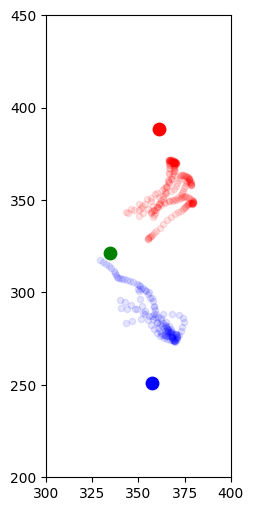

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))

color = 'Blue'
for i,row in cue_response_left.iterrows():

    mvmt_inx = row['matched_movement_index']
    segment = movements[mvmt_inx]
    ax.scatter(segment['x'], segment['y'], c=color, s=20, alpha=.1)

    if i > 400:
        break
ax.scatter(mean_spoutL['x'], mean_spoutL['y'], c=color, s=80, alpha=1)

color = 'Red'
for i,row in cue_response_right.iterrows():
    mvmt_inx = row['matched_movement_index']
    segment = movements[mvmt_inx]
    ax.scatter(segment['x'], segment['y'], c=color, s=20, alpha=.1)

    if i > 100:
        break
ax.scatter(mean_spoutR['x'], mean_spoutR['y'], c=color, s=80, alpha=1)

plt.xlim(300,400)
plt.ylim(200,450)
plt.gca().set_aspect('equal')

ax.scatter(mean_jaw['x'], mean_jaw['y'], c='Green', s=80, alpha=1)


plt.show()
    

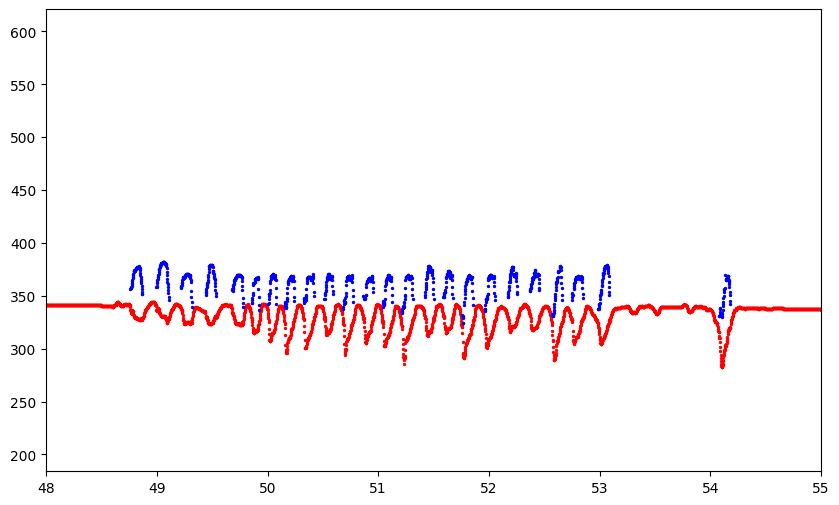

In [27]:
jaw_masked = mask_keypoint_data(keypoint_dfs_trimmed,'jaw',confidence_threshold=0.8)
jaw_masked.insert(0,'time',keypoint_timebase-keypoint_timebase[0])

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(jaw_masked['time'], jaw_masked['x'], c=color, s=2, alpha=1)
ax.scatter(tongue_masked['time'], tongue_masked['x'], c='blue', s=2, alpha=1)

plt.xlim(48,55)

plt.show()


In [28]:
cue_response_left.columns

Index(['timestamps', 'data', 'event', 'raw_timestamps', 'trial', 'time_video',
       'matched_movement_index', 'pre_ili', 'post_ili', 'bout_start',
       'bout_end', 'bout_number', 'rewarded', 'bout_rewarded', 'cue_response',
       'bout_cue_response', 'intertrial_choice', 'bout_intertrial_choice',
       'cue_switch', 'iti_switch', 'bout_cue_switch', 'bout_iti_switch',
       'within_session'],
      dtype='object')

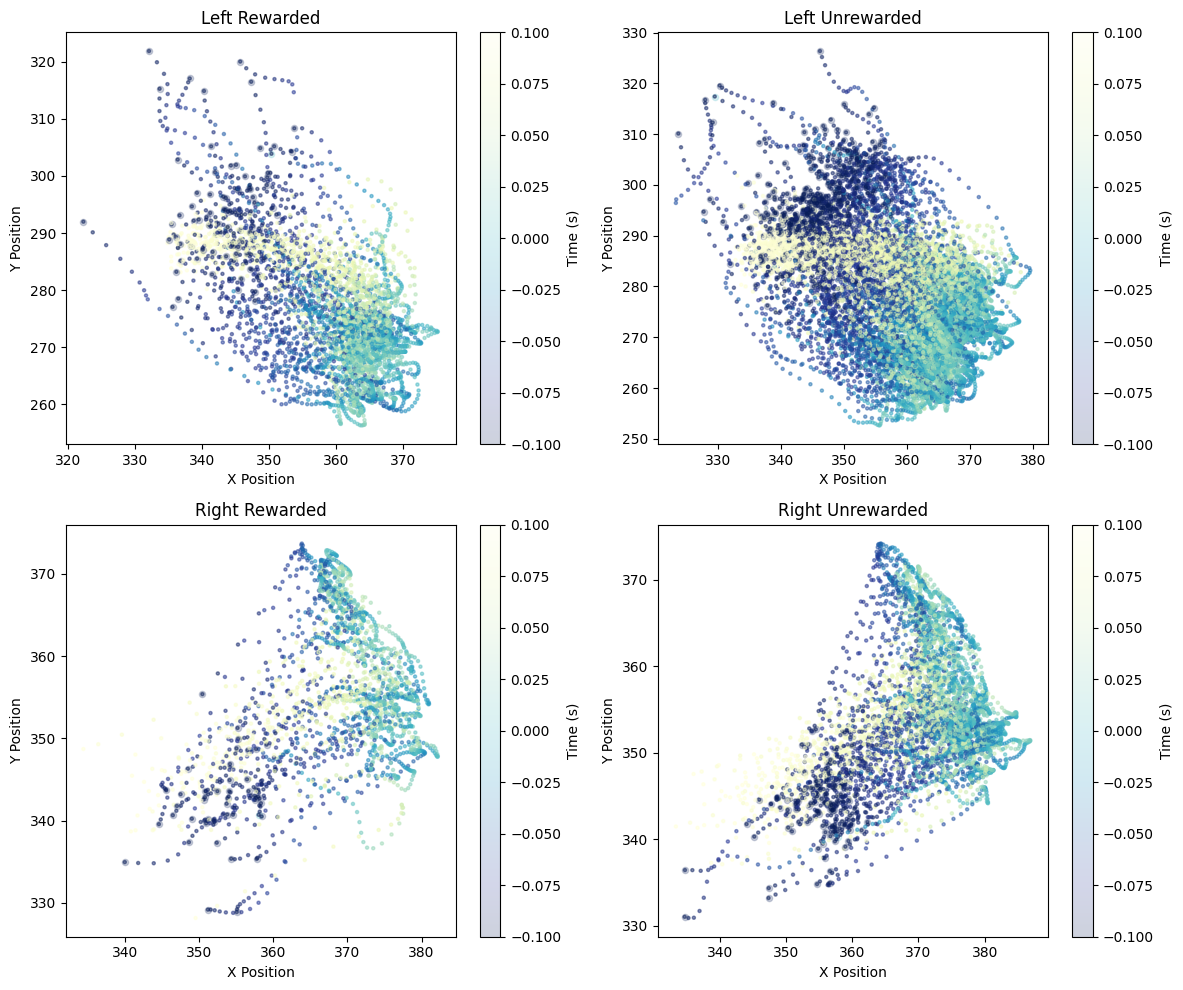

In [29]:
import matplotlib.pyplot as plt

# Get the indices for each DataFrame
left_rewarded_inx = left_rewarded['matched_movement_index'].values
left_unrewarded_inx = left_unrewarded['matched_movement_index'].values
right_rewarded_inx = right_rewarded['matched_movement_index'].values
right_unrewarded_inx = right_unrewarded['matched_movement_index'].values

# Create a 2x2 grid for the subplots (reward status x left/right)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Left Rewarded (top-left)
axes[0, 0].set_title("Left Rewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in left_rewarded_inx], ax=axes[0, 0])

# Left Unrewarded (top-right)
axes[0, 1].set_title("Left Unrewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in left_unrewarded_inx], ax=axes[0, 1])

# Right Rewarded (bottom-left)
axes[1, 0].set_title("Right Rewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in right_rewarded_inx], ax=axes[1, 0])

# Right Unrewarded (bottom-right)
axes[1, 1].set_title("Right Unrewarded")
plot_segmented_movements_global_time_colored([movements[i] for i in right_unrewarded_inx], ax=axes[1, 1])

# Adjust the layout to avoid overlap
plt.tight_layout()
plt.show()


In [30]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax=None, color='blue', alpha=0.8):
    """
    Plot segmented tongue movements with a specified color.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Optional Matplotlib axis to plot on (for subplots). If None, a new figure is created.
    - color: The color to use for plotting the segments.
    """
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Create a new figure if no axis is provided

    for i, segment in enumerate(segments):
        if not segment['x'].empty:
            # # Mark start point of each segment
            # ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0], c=color, s=20, alpha=alpha)

            # Plot each segment with the specified color
            ax.scatter(segment['x'], segment['y'], c=color, s=5, alpha=alpha)

    # Set labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    # If the function created a new figure, show it
    if ax is None:
        plt.tight_layout()
        plt.show()


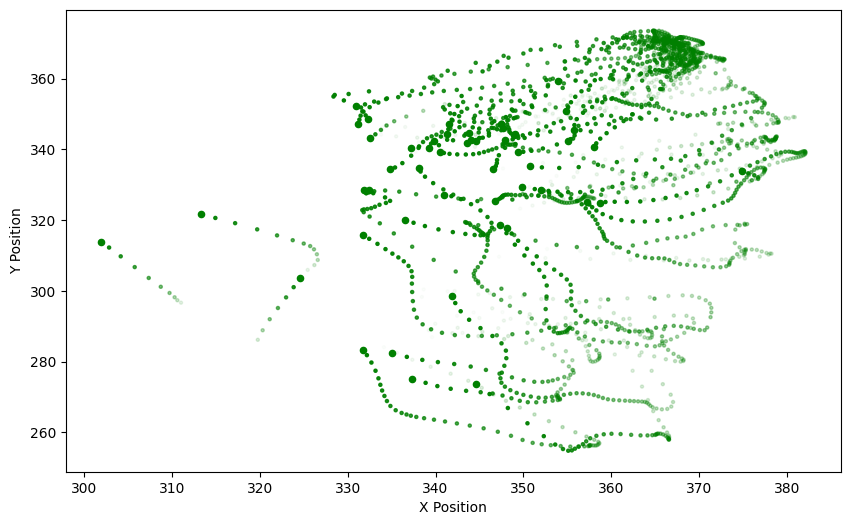

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax=None, color='blue'):
    """
    Plot segmented tongue movements with color representing the movement's time,
    and transparency representing the time since the first timepoint.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Optional Matplotlib axis to plot on (for subplots). If None, a new figure is created.
    - color: The color to use for plotting the segments.
    """
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Create a new figure if no axis is provided

    for i, segment in enumerate(segments):
        if not segment['x'].empty:
            # Normalize time to get a proportion of time since the first timepoint
            time_since_start = segment['time'] - segment['time'].iloc[0]
            max_time_since_start = time_since_start.max()  # Use the maximum time to normalize alpha
            
            # Map time to alpha: earlier times get darker (higher alpha), later times get lighter (lower alpha)
            norm_alpha = 1 - (time_since_start / max_time_since_start)  # Inverse: 0 = max time, 1 = min time
            
            # Mark start point of each segment (higher alpha at start)
            ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0], c=color, s=20, alpha=norm_alpha.iloc[0])

            # Plot each segment with color and time-based alpha
            ax.scatter(segment['x'], segment['y'], c=color, s=5, alpha=norm_alpha)

    # Set labels
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

    # If the function created a new figure, show it
    if ax is None:
        plt.tight_layout()
        plt.show()

# Example usage
plot_segmented_movements(movements[0:50], color='green')


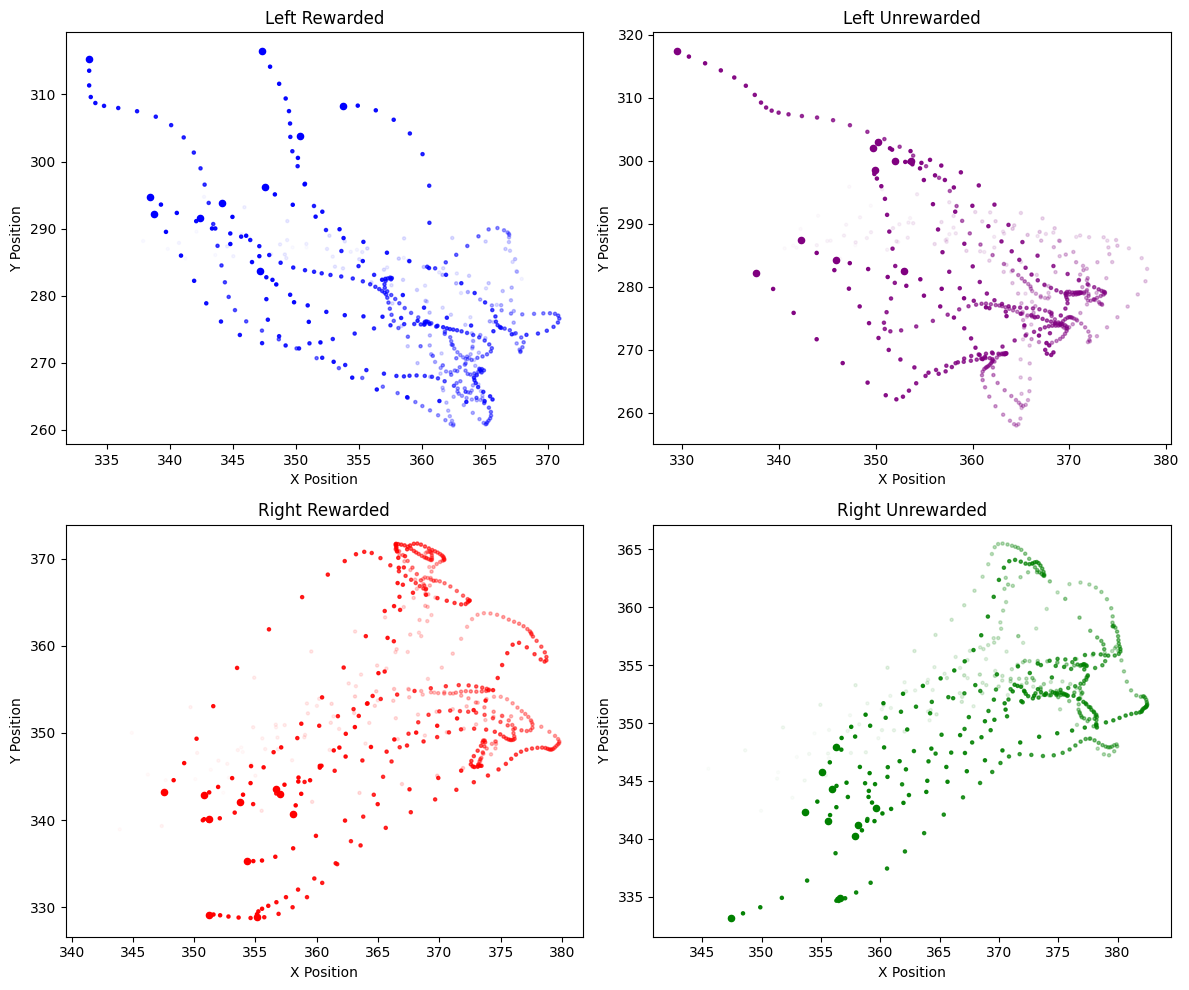

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax=None, color='blue'):
    """
    Plot segmented tongue movements with color representing the movement's time,
    and transparency representing the time since the first timepoint.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Optional Matplotlib axis to plot on (for subplots). If None, a new figure is created.
    - color: The color to use for plotting the segments.
    """
    # If no axis is provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))  # Create a new figure if no axis is provided

    for segment in segments:
        if not segment['x'].empty:
            # Normalize time to get a proportion of time since the first timepoint
            time_since_start = segment['time'] - segment['time'].iloc[0]
            max_time_since_start = time_since_start.max()  # Use the maximum time to normalize alpha
            
            # Map time to alpha: earlier times get darker (higher alpha), later times get lighter (lower alpha)
            norm_alpha = 1 - (time_since_start / max_time_since_start)  # Inverse: 0 = max time, 1 = min time
            
            # Mark start point of each segment (higher alpha at start)
            ax.scatter(segment['x'].iloc[0], segment['y'].iloc[0], c=color, s=20, alpha=norm_alpha.iloc[0])

            # Plot each segment with color and time-based alpha
            ax.scatter(segment['x'], segment['y'], c=color, s=5, alpha=norm_alpha)

    # Set labels
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')


# Create a 2x2 grid for the subplots (reward status x left/right)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # 2 rows, 2 columns

# Left Rewarded (Top-left)
axes[0, 0].set_title("Left Rewarded")
plot_segmented_movements([movements[i] for i in left_rewarded_inx[:10]], ax=axes[0, 0], color='Blue')

# Left Unrewarded (Top-right)
axes[0, 1].set_title("Left Unrewarded")
plot_segmented_movements([movements[i] for i in left_unrewarded_inx[:10]], ax=axes[0, 1], color='Purple')

# Right Rewarded (Bottom-left)
axes[1, 0].set_title("Right Rewarded")
plot_segmented_movements([movements[i] for i in right_rewarded_inx[:10]], ax=axes[1, 0], color='Red')

# Right Unrewarded (Bottom-right)
axes[1, 1].set_title("Right Unrewarded")
plot_segmented_movements([movements[i] for i in right_unrewarded_inx[:10]], ax=axes[1, 1], color='Green')

# Adjust layout
plt.tight_layout()
plt.show()


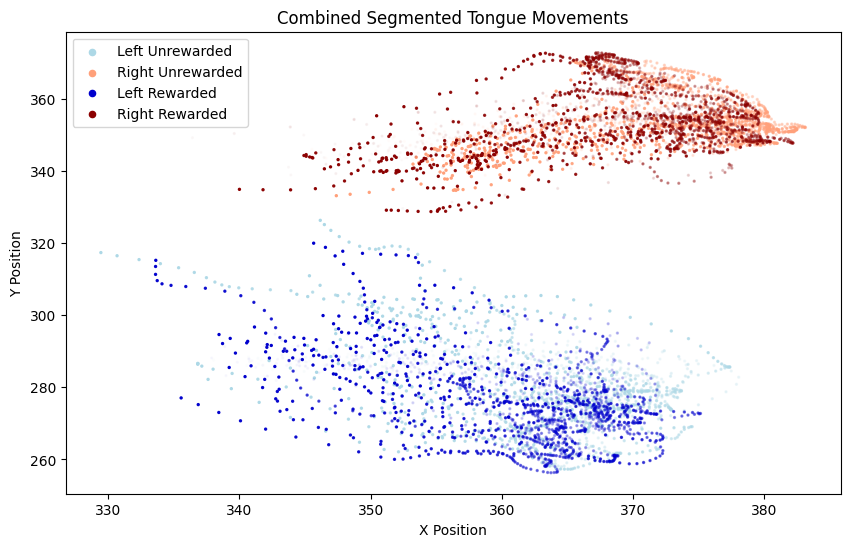

In [33]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_segmented_movements(segments, ax, color, label=None):
    """
    Plot segmented tongue movements with color and transparency representing the time since the first timepoint.

    Parameters:
    - segments: List of DataFrames containing 'x', 'y', and 'time' columns for each segment.
    - ax: Matplotlib axis to plot on.
    - color: The color to use for plotting the segments.
    - label: Label for the legend (only applied once per function call).
    """
    for segment in segments:
        if not segment['x'].empty:
            # Normalize time to get a proportion of time since the first timepoint
            time_since_start = segment['time'] - segment['time'].iloc[0]
            max_time_since_start = time_since_start.max() if len(time_since_start) > 0 else 1  # Avoid division by zero
            
            # Map time to alpha: earlier times get darker (higher alpha), later times get lighter (lower alpha)
            norm_alpha = 1 - (time_since_start / max_time_since_start) if max_time_since_start > 0 else 1
            
            # Plot each segment with color and time-based alpha
            ax.scatter(segment['x'], segment['y'], c=color, s=2, alpha=norm_alpha)

    # Add the legend entry once per category
    ax.scatter([], [], c=color, s=20, label=label)  # Dummy scatter for legend

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

sub_inx = range(0,30)

# Plot all movement categories on the same axis
plot_segmented_movements([movements[i] for i in left_unrewarded_inx[sub_inx]], ax, color='LightBlue', label='Left Unrewarded')
plot_segmented_movements([movements[i] for i in right_unrewarded_inx[sub_inx]], ax, color='LightSalmon', label='Right Unrewarded')
plot_segmented_movements([movements[i] for i in left_rewarded_inx[sub_inx]], ax, color='MediumBlue', label='Left Rewarded')
plot_segmented_movements([movements[i] for i in right_rewarded_inx[sub_inx]], ax, color='DarkRed', label='Right Rewarded')


# Set labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Combined Segmented Tongue Movements')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [34]:
#get first licks

df = nwb.df_events.copy()
# Assuming df is your dataframe
goCue_indices = df[df['event'] == 'goCue_start_time'].index  # Get indices of goCue_start_time
lick_indices = df[df['event'].isin(['left_lick_time', 'right_lick_time'])].index  # Get indices of lick events

# Find first lick index after each goCue
first_lick_indices = []
for goCue_idx in goCue_indices:
    next_licks = lick_indices[lick_indices > goCue_idx]  # Get lick indices after goCue
    if not next_licks.empty:
        first_lick_indices.append(next_licks[0])  # Store the first one

first_licks_df = df.iloc[first_lick_indices]


In [35]:
df_trials.columns


NameError: name 'df_trials' is not defined

In [ ]:
first_licks_df.head(20)

,timestamps,data,event,raw_timestamps,trial,time_video,matched_movement_index
14,0.660256,1.0,right_lick_time,3.892972e+06,0,49.237792,24
37,13.692288,1.0,right_lick_time,3.892985e+06,1,62.269824,53
73,30.028992,1.0,right_lick_time,3.893001e+06,2,78.606528,98
118,64.078976,1.0,right_lick_time,3.893035e+06,3,112.656512,155
167,136.896288,1.0,right_lick_time,3.893108e+06,4,185.473824,242
170,142.472736,1.0,right_lick_time,3.893113e+06,5,191.050272,246
177,150.077376,1.0,right_lick_time,3.893121e+06,6,198.654912,256
195,154.958912,1.0,right_lick_time,3.893126e+06,7,203.536448,274
225,170.600032,1.0,right_lick_time,3.893141e+06,8,219.177568,313
247,177.223104,1.0,right_lick_time,3.893148e+06,9,225.800640,335


In [ ]:
# old plotting functions